In [1]:
import gpr
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

This notebook will provide a demo for how to estimate metallicities using our Gaussian Process Regressor. For the data used in this example, we will be using the first 50,000 rows from the Gaia high proper motion cross match from Medan, Lepine and Hartman (2020).

In [2]:
data=pd.read_csv('GAIA_DR2_star_40mas_best_bayes_matches_all_phot_GITHUB_SAMPLE_TAB.txt')

To use the provided code to estimate metallicites, data must be loaded as a Pandas dataframe with the same column names as the cross match table provided here. The column names for the table are printed below, and can be found in our paper.

In [3]:
print(data.columns)

Index(['GAIA_ID', 'G', 'BP', 'RP', 'RA_GAIA', 'DE_GAIA', 'PLX', 'PLX_ERR',
       'PMRA', 'PMDE', 'SDSSID', 'u_SDSS', 'uerr_SDSS', 'g_SDSS', 'gerr_SDSS',
       'r_SDSS', 'rerr_SDSS', 'i_SDSS', 'ierr_SDSS', 'z_SDSS', 'zerr_SDSS',
       'RA_SDSS', 'DE_SDSS', 'bayes_SDSS', 'angsep_SDSS', '2MASS_ID',
       'J_2MASS', 'Jerr_2MASS', 'H_2MASS', 'Herr_2MASS', 'K_2MASS',
       'Kerr_2MASS', 'RA_2MASS', 'DE_2MASS', 'bayes_2MASS', 'angsep_2MASS',
       'ALLWISE_ID', 'W1_ALLWISE', 'W1err_ALLWISE', 'W2_ALLWISE',
       'W2err_ALLWISE', 'W3_ALLWISE', 'W3err_ALLWISE', 'W4_ALLWISE',
       'W4err_ALLWISE', 'RA_ALLWISE', 'DE_ALL_WISE', 'bayes_ALLWISE',
       'angsep_ALLWISE', 'GALEX_ID', 'FUV_GALEX', 'FUVerr_GALEX', 'NUV_GALEX',
       'NUVerr_GALEX', 'RA_GALEX', 'DE_GALEX', 'bayes_GALEX', 'angsep_GALEX',
       'PS1_ID', 'g_PS1', 'gerr_PS1', 'r_PS1', 'rerr_PS1', 'i_PS1', 'ierr_PS1',
       'z_PS1', 'zerr_PS1', 'y_PS1', 'yerr_PS1', 'RA_PS1', 'DE_PS1',
       'bayes_PS1', 'angsep_PS1', 'RAVE_ID', 

Since there are two calibrated relationships for two different stellar temperature regimes, we have to apply some temperature cuts (by color). In addition, with these cuts we will also ensure that all stars in the sample have the required photometry for each regressor. This is done below for the K dwarf regressor (i.e. 3500 < T < 5280 K) and M dwarf regressor (i.e. 2850 < T < 3500 K).

In [4]:
K_cols=['z_PS1','g_PS1','J_2MASS','y_PS1','W1_ALLWISE','W2_ALLWISE','H_2MASS']
ev_strK="(data['PLX']>0) & (data['BP']-data['RP']>0.98) & (data['BP']-data['RP']<2.39) & (data['PLX_ERR']/data['PLX']<0.2) & (data['g_PS1']>13.5)"
for i in range(len(K_cols)):
    ev_strK+="& (abs(data['%s'])<99.)" % K_cols[i]
ev_K_cols=eval(ev_strK)

In [5]:
M_cols=['g_PS1','H_2MASS','W1_ALLWISE','y_PS1','W2_ALLWISE','r_PS1','W1_ALLWISE']
ev_strM="(data['PLX']>0) & (data['BP']-data['RP']>2.39) & (data['BP']-data['RP']<5) & (data['PLX_ERR']/data['PLX']<0.2) & (data['g_PS1']>13.5)"
for i in range(len(M_cols)):
    ev_strM+="& (abs(data['%s'])<99.)" % M_cols[i]
ev_M_cols=eval(ev_strM)

Now we can estimate the metallicities and the confidence on these estimates.

In [6]:
data['M_H']=99.
data['M_H_std']=99.

data['M_H'][ev_K_cols],data['M_H_std'][ev_K_cols]=gpr.estimate_metals_gpr(data[ev_K_cols],'K_dwarf_classifier.joblib.pkl','K_dwarf_cuts.pkl','K')
data['M_H'][ev_M_cols],data['M_H_std'][ev_M_cols]=gpr.estimate_metals_gpr(data[ev_M_cols],'M_dwarf_classifier.joblib.pkl','M_dwarf_cuts.pkl','M')

Now let us look at the results from the regressor. In these plots the left panel shows the estimated metallicities and the right panel the 95% confidence interval on these estimates.

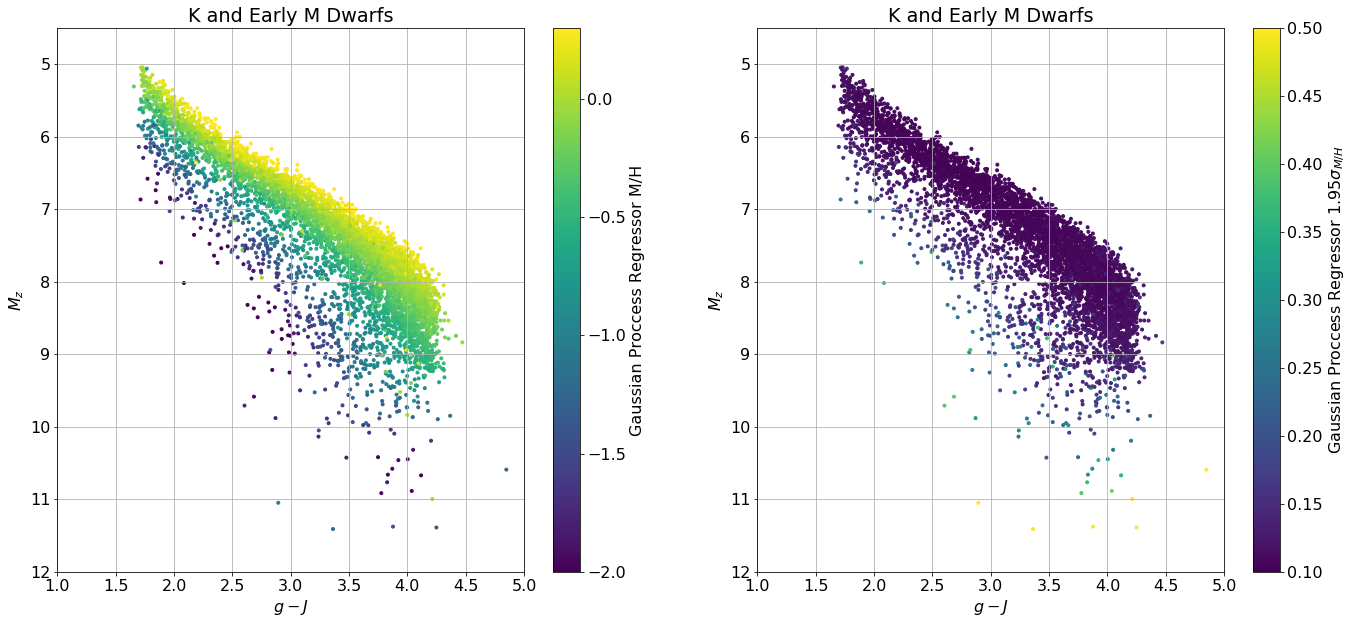

In [7]:
plt.rcParams.update({'font.size': 16})
col1='g_PS1'
col2='J_2MASS'
mag='z_PS1'
boundx=(1,5)
boundy=(4.5,12)

fig = plt.figure(figsize=(23,10))
ax = fig.add_subplot(1, 2, 1)
density=ax.scatter(data[col1][ev_K_cols & (data['M_H']!=99.)]-data[col2][ev_K_cols & (data['M_H']!=99.)],data[mag][ev_K_cols & (data['M_H']!=99.)]+5*np.log10(1e-3*data['PLX'][ev_K_cols & (data['M_H']!=99.)])+5,marker='.',c=data['M_H'][ev_K_cols & (data['M_H']!=99.)],vmin=-2,vmax=0.3)
#ax.grid()
fig.colorbar(density, label='Gaussian Proccess Regressor M/H')
ax.set_xlabel(r'$g-J$')
ax.set_ylabel(r'$M_z$')
ax.set_title('K and Early M Dwarfs')
ax.set_xlim(boundx)
ax.set_ylim(boundy)
ax.grid()
ax.invert_yaxis()

ax2 = fig.add_subplot(1, 2, 2)
density=ax2.scatter(data[col1][ev_K_cols & (data['M_H']!=99.)]-data[col2][ev_K_cols & (data['M_H']!=99.)],data[mag][ev_K_cols & (data['M_H']!=99.)]+5*np.log10(1e-3*data['PLX'][ev_K_cols & (data['M_H']!=99.)])+5,marker='.',c=data['M_H_std'][ev_K_cols & (data['M_H']!=99.)]*1.95,vmin=0.1,vmax=0.5)
#ax.grid()
fig.colorbar(density, label=r'Gaussian Proccess Regressor $1.95\sigma_{M/H}$')
ax2.set_xlabel(r'$g-J$')
ax2.set_ylabel(r'$M_z$')
ax2.set_title('K and Early M Dwarfs')
ax2.set_xlim(boundx)
ax2.set_ylim(boundy)
ax2.grid()
ax2.invert_yaxis()
plt.show()

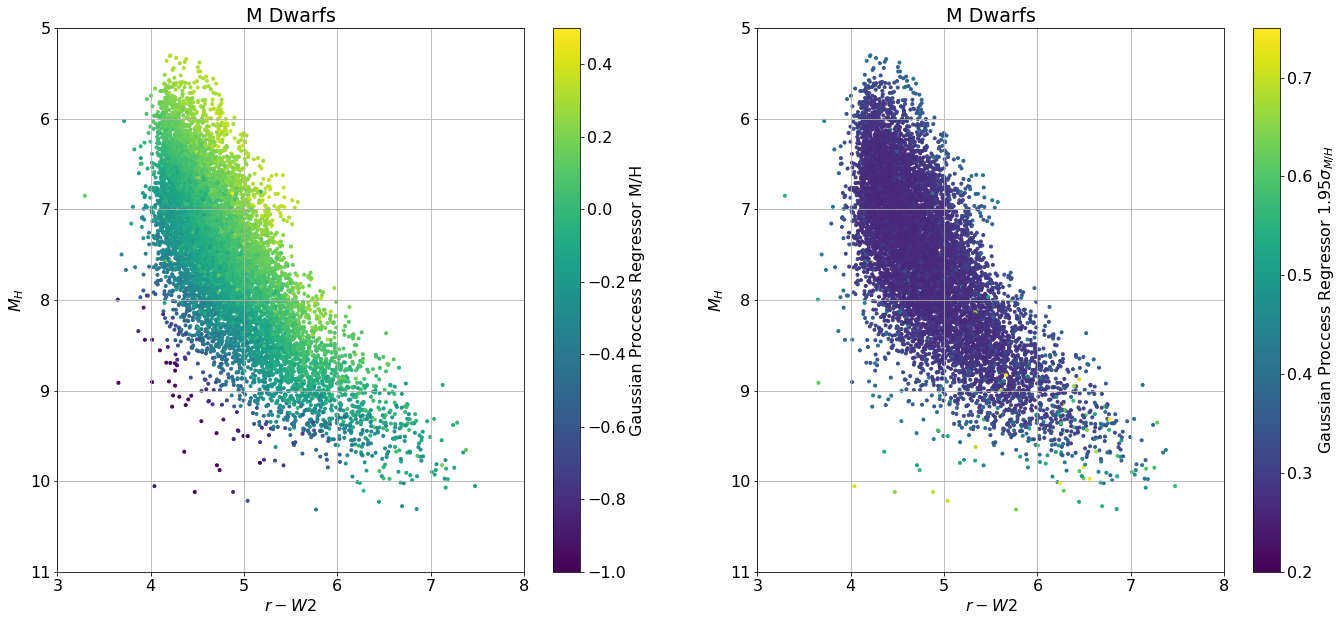

In [8]:
plt.rcParams.update({'font.size': 16})
col1='r_PS1'
col2='W2_ALLWISE'
mag='H_2MASS'
boundx=(3,8)
boundy=(5,11)

fig = plt.figure(figsize=(23,10))
ax = fig.add_subplot(1, 2, 1)
density=ax.scatter(data[col1][ev_M_cols & (data['M_H']!=99.)]-data[col2][ev_M_cols & (data['M_H']!=99.)],data[mag][ev_M_cols & (data['M_H']!=99.)]+5*np.log10(1e-3*data['PLX'][ev_M_cols & (data['M_H']!=99.)])+5,marker='.',c=data['M_H'][ev_M_cols & (data['M_H']!=99.)],vmin=-1,vmax=0.5)
#ax.grid()
fig.colorbar(density, label='Gaussian Proccess Regressor M/H')
ax.set_xlabel(r'$r-W2$')
ax.set_ylabel(r'$M_H$')
ax.set_title('M Dwarfs')
ax.set_xlim(boundx)
ax.set_ylim(boundy)
ax.grid()
ax.invert_yaxis()

ax2 = fig.add_subplot(1, 2, 2)
density=ax2.scatter(data[col1][ev_M_cols & (data['M_H']!=99.)]-data[col2][ev_M_cols & (data['M_H']!=99.)],data[mag][ev_M_cols & (data['M_H']!=99.)]+5*np.log10(1e-3*data['PLX'][ev_M_cols & (data['M_H']!=99.)])+5,marker='.',c=data['M_H_std'][ev_M_cols & (data['M_H']!=99.)]*1.95,vmin=0.2,vmax=0.75)
#ax.grid()
fig.colorbar(density, label=r'Gaussian Proccess Regressor $1.95\sigma_{M/H}$')
ax2.set_xlabel(r'$r-W2$')
ax2.set_ylabel(r'$M_H$')
ax2.set_title('M Dwarfs')
ax2.set_xlim(boundx)
ax2.set_ylim(boundy)
ax2.grid()
ax2.invert_yaxis()
plt.show()